In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
datapath = 'ml-100k/' 

In [3]:
ratings = pd.read_csv(datapath + 'u.data', sep='\t', names=['user_id', 'item_id', 'rating', 'timestamp'])

In [4]:
ratings

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596
...,...,...,...,...
99995,880,476,3,880175444
99996,716,204,5,879795543
99997,276,1090,1,874795795
99998,13,225,2,882399156


In [5]:
# Number of users and items
num_users = ratings['user_id'].max()
num_items = ratings['item_id'].max()

In [6]:
num_users

np.int64(943)

In [7]:
num_items

np.int64(1682)

In [8]:
# Create user-item interaction matrix
user_item_matrix = np.zeros((num_users, num_items))

In [9]:
# Fill the matrix with ratings
for row in ratings.itertuples():
    user_item_matrix[row.user_id - 1, row.item_id - 1] = row.rating

In [10]:
# Convert to PyTorch tensor
user_item_matrix = torch.FloatTensor(user_item_matrix)

In [11]:
user_item_matrix.shape

torch.Size([943, 1682])

In [12]:
# Train-test split
train_data, test_data = train_test_split(ratings, test_size=0.2, random_state=102)

# Mask for train-test split
train_matrix = user_item_matrix.clone()
test_matrix = user_item_matrix.clone()

In [13]:
train_data.shape

(80000, 4)

In [14]:
test_data.shape

(20000, 4)

In [15]:
for row in test_data.itertuples():
    train_matrix[row.user_id - 1, row.item_id - 1] = 0  # Mask out test data in train matrix
    test_matrix[row.user_id - 1, row.item_id - 1] = row.rating

In [16]:
train_matrix

tensor([[5., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]])

In [17]:
test_matrix

tensor([[5., 3., 4.,  ..., 0., 0., 0.],
        [4., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [5., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 5., 0.,  ..., 0., 0., 0.]])

In [18]:
class AutoRec(nn.Module):
    def __init__(self, num_items, hidden_dim, lambda_):
        super(AutoRec, self).__init__()
        self.lambda_ = lambda_
        self.encoder = nn.Linear(num_items, hidden_dim, bias=True)
        self.decoder = nn.Linear(hidden_dim, num_items, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        encoded = self.sigmoid(self.encoder(x))
        decoded = self.decoder(encoded)
        return decoded

    def regularization_loss(self):
        reg_loss = 0
        for param in self.parameters():
            reg_loss += param.norm(2)
        return self.lambda_ * reg_loss

In [19]:
def train_epoch(model, train_data, optimizer, criterion, batch_size):
    model.train()
    num_batches = train_data.size(0) // batch_size
    total_loss = 0

    for i in range(num_batches):
        batch = train_data[i * batch_size:(i + 1) * batch_size].to(device)

        optimizer.zero_grad()
        predictions = model(batch)
        mask = batch > 0 
        loss = criterion(predictions[mask], batch[mask]) + model.regularization_loss()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / num_batches


In [20]:
def evaluate_model(model, test_data, criterion, batch_size):
    model.eval()
    num_batches = test_data.size(0) // batch_size
    total_loss = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = test_data[i * batch_size:(i + 1) * batch_size].to(device)

            predictions = model(batch)
            mask = batch > 0  # Mask for non-zero ratings
            loss = criterion(predictions[mask], batch[mask])
            total_loss += loss.item()

    return total_loss / num_batches

In [21]:
# Hyperparameters
hidden_dim = 1000
lambda_ = 0.0001
learning_rate = 0.001
batch_size = 32
epochs = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [22]:
# Initialize model, optimizer, and loss function
model = AutoRec(num_items, hidden_dim, lambda_).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)
criterion = nn.MSELoss()

In [23]:
train_tensor = train_matrix.to(device)
test_tensor = test_matrix.to(device)

In [24]:
train_losses, test_losses = [], []

In [25]:
for epoch in range(epochs):
    train_loss = train_epoch(model, train_tensor, optimizer, criterion, batch_size)
    test_loss = evaluate_model(model, test_tensor, criterion, batch_size)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/128, Train Loss: 2.8758, Test Loss: 1.1498
Epoch 2/128, Train Loss: 1.1642, Test Loss: 1.0509
Epoch 3/128, Train Loss: 1.0476, Test Loss: 0.9730
Epoch 4/128, Train Loss: 0.9489, Test Loss: 0.8969
Epoch 5/128, Train Loss: 0.8538, Test Loss: 0.8345
Epoch 6/128, Train Loss: 0.7666, Test Loss: 0.7723
Epoch 7/128, Train Loss: 0.6873, Test Loss: 0.7465
Epoch 8/128, Train Loss: 0.6228, Test Loss: 0.7431
Epoch 9/128, Train Loss: 0.6023, Test Loss: 1.0213
Epoch 10/128, Train Loss: 0.6443, Test Loss: 1.3708
Epoch 11/128, Train Loss: 0.8598, Test Loss: 0.7559
Epoch 12/128, Train Loss: 0.5770, Test Loss: 0.5848
Epoch 13/128, Train Loss: 0.4079, Test Loss: 0.5142
Epoch 14/128, Train Loss: 0.3726, Test Loss: 0.4935
Epoch 15/128, Train Loss: 0.3207, Test Loss: 0.4911
Epoch 16/128, Train Loss: 0.2845, Test Loss: 0.4762
Epoch 17/128, Train Loss: 0.2600, Test Loss: 0.4506
Epoch 18/128, Train Loss: 0.2392, Test Loss: 0.4542
Epoch 19/128, Train Loss: 0.2199, Test Loss: 0.5053
Epoch 20/128, Train L

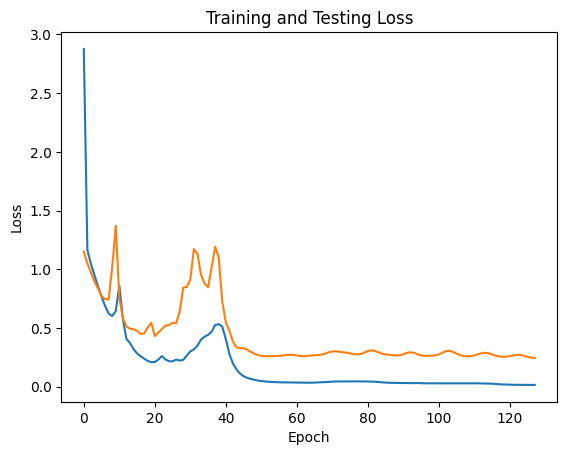

In [26]:
# Plot losses
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.show()

In [27]:
def calculate_rmse(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mse = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            mse += ((predictions[mask] - batch[mask]) ** 2).sum().item()
            total_ratings += mask.sum().item()

    return np.sqrt(mse / total_ratings)

In [28]:
rmse = calculate_rmse(model, test_tensor, batch_size)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.4955


# Choosing hyperparameters

Best combination in 50 epochs with ADAM is:
{'hidden_dim': 1000, 'lambda_': 0.0001, 'learning_rate': 0.001, 'batch_size': 32, 'betas': (0.9, 0.99), 'eps': 1e-07, 'amsgrad': True}

Best RMSE: 0.5019


In [29]:
# import itertools

# param_grid = {
#     'hidden_dim': [100, 500, 1000],
#     'lambda_': [0.0001, 0.001],
#     'learning_rate': [0.01, 0.001, 0.015],
#     'batch_size': [32, 64, 128, 256, 512],
#     'betas': [(0.9, 0.999), (0.9, 0.99), (0.8, 0.999)],
#     'eps': [1e-8, 1e-7, 1e-6],
#     'amsgrad': [False, True],
# }

# param_combinations = list(itertools.product(*param_grid.values()))

# def train_and_evaluate(params, train_matrix, test_matrix):
#     # Unpack parameters
#     hidden_dim, lambda_, learning_rate, batch_size, betas, eps, amsgrad = params

#     model = AutoRec(num_items, hidden_dim, lambda_).to(device)
#     optimizer = torch.optim.Adam(
#         model.parameters(),
#         lr=learning_rate,
#         betas=betas,
#         eps=eps,
#         amsgrad=amsgrad
#     )
#     criterion = nn.MSELoss()
    
#     train_tensor = train_matrix.to(device)
#     test_tensor = test_matrix.to(device)

#     for epoch in range(50):
#         train_epoch(model, train_tensor, optimizer, criterion, batch_size)

#     rmse = calculate_rmse(model, test_tensor, batch_size)
#     return rmse

# best_params = None
# best_rmse = float('inf')

# for i, params in enumerate(param_combinations):
#     print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")
#     rmse = train_and_evaluate(params, train_matrix, test_matrix)
    
#     print(f"RMSE: {rmse:.4f}")
    
#     if rmse < best_rmse:
#         best_rmse = rmse
#         best_params = params

# best_param_dict = dict(zip(param_grid.keys(), best_params))
# print(f"\nBest Hyperparameters: {best_param_dict}")
# print(f"Best RMSE: {best_rmse:.4f}")
